In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
%matplotlib inline
sp.init_printing()

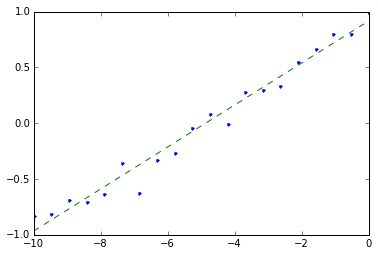

In [2]:
X = np.vstack([np.linspace(-10, 0, 20), np.ones(20)]).T
y = np.linspace(-1, 1, 20) + np.random.randn(20)*0.1
B = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))

plt.plot(X[:, 0], y, '.')

plt.plot(X[:, 0], np.dot(X, B), '--')

In [105]:
np.linalg.inv(np.dot(X.T, X))

array([[ 0.00542857,  0.02714286],
       [ 0.02714286,  0.18571429]])

In [106]:
B

array([ 0.20507151,  0.99950092])

In [95]:
np.dot(X, B).T - y

array([ 0.27559026,  0.09567109,  0.43089431, -0.10237317,  0.04768405,
        0.03102591, -0.20429733,  0.03103837, -0.1550533 , -0.26963858,
       -0.05420966, -0.08228222, -0.20143815, -0.0459794 , -0.12005627,
       -0.07579049,  0.07817814,  0.00498967,  0.20671372,  0.10933305])

In [96]:
np.dot((np.dot(X, B) - y).T, np.dot(X, B) - y)

0.55731594973926846

In [97]:
np.dot(B.T, np.dot(np.dot(X.T, X), B)) - 2*np.dot(np.dot(X, B).T, y) + np.dot(y.T, y)

0.55731594973926679

In [98]:
np.linalg.cholesky(np.linalg.inv(np.dot(X.T, X))*Out[68])

array([[ 0.00247118,  0.        ],
       [-0.08454053,  0.07769152]])

In [167]:
# formulation w/ neat latex / greek symbols

f, h, ye, psie, w, xk, v, k, dt = sp.symbols("f, h, y_e, \psi_e, \omega, x_k, v, \kappa, \delta_t")
Cv, Tv, Cs, Ts, u_steering, u_acceleration = sp.symbols("C_v, T_v, C_s, T_s, u_\delta, u_a")
mu_s, mu_g, mu_ax, mu_ay = sp.symbols("\mu_\delta \mu_g, \mu_{a_x}, \mu_{a_y}")

In [217]:
# source code friendly formulation

f, h, ye, psie, w, xk, v, k, dt = sp.symbols("f, h, ye, psie, w, xk, v, k, dt")
Cv, Tv, Cs, Ts, u_steering, u_acceleration = sp.symbols("Cv, Tv, Cs, Ts, u_steering, u_acceleration")
mu_s, mu_g, mu_ax, mu_ay = sp.symbols("mu_s mu_g mu_ax, mu_ay")

In [218]:
f, h, ye, psie, w, xk, v, k, dt

In [219]:
Cv, Tv, Cs, Ts, u_steering, u_acceleration

In [220]:
mu_s, mu_g, mu_ax, mu_ay  # steering and gyroscope bias

In [221]:
X = sp.Matrix([[ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay]])
X

[ye  psie  w  v  k  Cv  Tv  Cs  Ts  μ_s  μ_g  μₐₓ  μ_ay]

In [236]:
# dynamic state variables f(x)
# the clipped traction limit is an argument for a UKF here unless we use tanh or something

eCv, eTv, eCs, eTs = sp.exp(Cv), sp.exp(Tv), sp.exp(Cs), sp.exp(Ts)
fx = sp.Matrix([
        [ye - dt*v * sp.sin(psie),
         psie + dt*(w + v * k * sp.cos(psie) / (1 - k * ye)),
         w + dt*(v*eCs*(u_steering - mu_s) - w) / eTs,  # fixme: this should be clipped at some traction limit
         v + dt*(eCv * u_acceleration - v) / eTv,
         k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay
        ]])
fx.T



⎡           -dt⋅v⋅sin(psie) + ye            ⎤
⎢                                           ⎥
⎢          ⎛k⋅v⋅cos(psie)    ⎞              ⎥
⎢       dt⋅⎜───────────── + w⎟ + psie       ⎥
⎢          ⎝  -k⋅ye + 1      ⎠              ⎥
⎢                                           ⎥
⎢   ⎛                       Cs    ⎞  -Ts    ⎥
⎢dt⋅⎝v⋅(-μ_s + u_steering)⋅ℯ   - w⎠⋅ℯ    + w⎥
⎢                                           ⎥
⎢      ⎛                Cv    ⎞  -Tv        ⎥
⎢   dt⋅⎝u_acceleration⋅ℯ   - v⎠⋅ℯ    + v    ⎥
⎢                                           ⎥
⎢                     k                     ⎥
⎢                                           ⎥
⎢                    Cv                     ⎥
⎢                                           ⎥
⎢                    Tv                     ⎥
⎢                                           ⎥
⎢                    Cs                     ⎥
⎢                                           ⎥
⎢                    Ts                     ⎥
⎢                                 

In [237]:
Fx = sp.simplify(sp.Matrix([sp.diff(fx, Xj) for Xj in X]).T)
Fx

⎡        1                -dt⋅v⋅cos(psie)              0                 -dt⋅s
⎢                                                                             
⎢    2                                                                        
⎢dt⋅k ⋅v⋅cos(psie)  dt⋅k⋅v⋅sin(psie) + k⋅ye - 1                        -dt⋅k⋅c
⎢─────────────────  ───────────────────────────       dt               ───────
⎢             2               k⋅ye - 1                                     k⋅y
⎢   (k⋅ye - 1)                                                                
⎢                                                                             
⎢                                                      -Ts                    
⎢        0                       0               - dt⋅ℯ    + 1  -dt⋅(μ_s - u_s
⎢                                                                             
⎢                                                                             
⎢        0                       0                  

In [238]:
sp.print_python(Fx)

dt = Symbol('dt')
v = Symbol('v')
psie = Symbol('psie')
k = Symbol('k')
ye = Symbol('ye')
Ts = Symbol('Ts')
mu_s = Symbol('mu_s')
u_steering = Symbol('u_steering')
Cs = Symbol('Cs')
w = Symbol('w')
Tv = Symbol('Tv')
u_acceleration = Symbol('u_acceleration')
Cv = Symbol('Cv')
e = ImmutableMatrix([[1, -dt*v*cos(psie), 0, -dt*sin(psie), 0, 0, 0, 0, 0, 0, 0, 0, 0], [dt*k**2*v*cos(psie)/(k*ye - 1)**2, (dt*k*v*sin(psie) + k*ye - 1)/(k*ye - 1), dt, -dt*k*cos(psie)/(k*ye - 1), dt*v*cos(psie)/(k*ye - 1)**2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, -dt*exp(-Ts) + 1, -dt*(mu_s - u_steering)*exp(Cs - Ts), 0, 0, 0, -dt*v*(mu_s - u_steering)*exp(Cs - Ts), dt*(v*(mu_s - u_steering)*exp(Cs) + w)*exp(-Ts), -dt*v*exp(Cs - Ts), 0, 0, 0], [0, 0, 0, -dt*exp(-Tv) + 1, 0, dt*u_acceleration*exp(Cv - Tv), dt*(-u_acceleration*exp(Cv) + v)*exp(-Tv), 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [225]:
# h
hx = sp.Matrix([[ye / sp.cos(psie), sp.tan(psie)]])  # measuring b, m
hx.T

⎡    ye   ⎤
⎢─────────⎥
⎢cos(psie)⎥
⎢         ⎥
⎣tan(psie)⎦

In [226]:
# H
Hx = sp.simplify(sp.Matrix([sp.diff(hx, Xj) for Xj in X]).T)
sp.print_python(Hx.subs([(psie, "psie"), (ye, "ye")]))
Hx

psie = Symbol('psie')
ye = Symbol('ye')
e = ImmutableMatrix([[1/cos(psie), ye*sin(psie)/cos(psie)**2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, cos(psie)**(-2), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


⎡    1      ye⋅sin(psie)                                 ⎤
⎢─────────  ────────────  0  0  0  0  0  0  0  0  0  0  0⎥
⎢cos(psie)      2                                        ⎥
⎢            cos (psie)                                  ⎥
⎢                                                        ⎥
⎢                1                                       ⎥
⎢    0       ──────────   0  0  0  0  0  0  0  0  0  0  0⎥
⎢               2                                        ⎥
⎣            cos (psie)                                  ⎦

In [177]:
X

[yₑ  \psiₑ  \omega  v  \kappa  Cᵥ  Tᵥ  C_s  T_s  \mu_\delta  \mu_g  \mu_{a_x} 
 \mu_{a_y}]

In [230]:
# measure gyro_z, accel_x, accel_y
h_imu = sp.Matrix([[
            w + mu_g,
            v*w + mu_ax,
            -(sp.exp(Cv) * u_acceleration - v) / sp.exp(Tv) + mu_ay,
        ]])
h_imu.T

⎡               μ_g + w                ⎤
⎢                                      ⎥
⎢              μₐₓ + v⋅w               ⎥
⎢                                      ⎥
⎢       ⎛                  Cv    ⎞  -Tv⎥
⎣μ_ay + ⎝- u_acceleration⋅ℯ   + v⎠⋅ℯ   ⎦

In [231]:
H_imu = sp.simplify(sp.Matrix([sp.diff(h_imu, Xj) for Xj in X]).T)
H_imu

⎡0  0  1   0    0             0                            0                0 
⎢                                                                             
⎢0  0  v   w    0             0                            0                0 
⎢                                                                             
⎢          -Tv                      Cv - Tv  ⎛                Cv    ⎞  -Tv    
⎣0  0  0  ℯ     0  -u_acceleration⋅ℯ         ⎝u_acceleration⋅ℯ   - v⎠⋅ℯ     0 

 0  0  1  0  0⎤
              ⎥
 0  0  0  1  0⎥
              ⎥
              ⎥
 0  0  0  0  1⎦

In [232]:
sp.print_python(H_imu)

v = Symbol('v')
w = Symbol('w')
Tv = Symbol('Tv')
u_acceleration = Symbol('u_acceleration')
Cv = Symbol('Cv')
e = ImmutableMatrix([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, v, w, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, exp(-Tv), 0, -u_acceleration*exp(Cv - Tv), (u_acceleration*exp(Cv) - v)*exp(-Tv), 0, 0, 0, 0, 0, 1]])
